In [1]:
import pandas as pd
import numpy as np

import chess.pgn
from stockfish import Stockfish

import matplotlib.pyplot as plt
# import seaborn as sns

In [2]:
# stockfish init
stockfish = Stockfish(
    'stockfish_14_linux_x64/stockfish_14_linux_x64/stockfish_14_x64', 
    parameters={"Threads": 2, 'Min Split Depth': 26, 'Ponder':True}
)
stockfish.set_elo_rating(2600)
stockfish.set_skill_level(30)

In [3]:
%%time
# games dict
games = {
    'White':[],
    'White_Elo': [],
    'Black': [],
    'Black_Elo': [],
    'ECO': [],
    'Result': [],
    'FEN_moves': [],
    'cpl':[],
    'Comp':[],
}

# read file
pgn = open("data/Fics_data_pc_data.pgn", encoding='UTF-8')  # either player is always a Comp
game_counter = 0

while True:
    try:
        game = chess.pgn.read_game(pgn)
        board = game.board()
        moves = list(game.mainline_moves())
        
        # HEADERS
        games['White_Elo'].append(game.headers['WhiteElo'])
        games['Black_Elo'].append(game.headers['BlackElo'])
        games['White'].append(game.headers['White'])
        games['Black'].append(game.headers['Black'])
        games['Result'].append(game.headers['Result'])
        games['ECO'].append(game.headers['ECO'])
        games['Comp'].append(game.headers.get('WhiteIsComp', 'No'))
        
        # MOVES
        fen_pos = []
        acpl = []

        # MOVE CYCLE
        for move in moves:
            board.push(move)
            fen_pos.append(board.fen())
            stockfish.set_fen_position(board.fen())  # load stockfish with current fen for eval
            cpl = stockfish.get_evaluation()['value']/100
            acpl.append(cpl)

        games['FEN_moves'].append(fen_pos)
        games['cpl'].append(acpl)
        
        game_counter += 1
        if game_counter == 8:  # number of games to read
            break
    except AttributeError:  # no further games to read
        print('No further games to load.')
        break

print(f'{game_counter} games read.')

8 games read.
CPU times: user 230 ms, sys: 7.02 ms, total: 237 ms
Wall time: 1.61 s


#### fics total number of games:

5272 games read.
No further games to load.

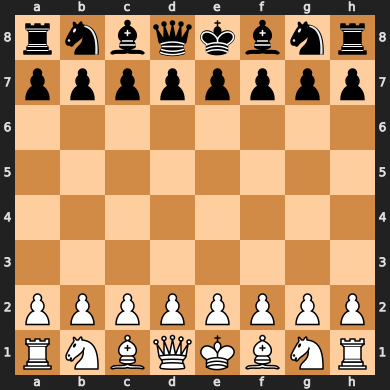

In [15]:
game.board()

In [5]:
print(game) #.mainline_moves()

[Event "FICS rated blitz game"]
[Site "FICS freechess.org"]
[Date "2021.01.31"]
[Round "?"]
[White "forlat"]
[Black "Geforce"]
[Result "0-1"]
[BlackClock "0:03:00.000"]
[BlackElo "2210"]
[BlackRD "0.0"]
[ECO "C28"]
[FICSGamesDBGameNo "490373432"]
[PlyCount "94"]
[Time "23:26:00"]
[TimeControl "180+0"]
[WhiteClock "0:03:00.000"]
[WhiteElo "1964"]
[WhiteIsComp "Yes"]
[WhiteRD "0.0"]

1. e4 { [%emt 0.0] } 1... e5 { [%emt 0.0] } 2. Bc4 { [%emt 0.214] } 2... Nc6 { [%emt 0.636] } 3. Nc3 { [%emt 0.214] } 3... Nf6 { [%emt 1.134] } 4. d3 { [%emt 0.215] } 4... Bc5 { [%emt 1.039] } 5. Nh3 { [%emt 1.173] } 5... h6 { [%emt 6.733] } 6. O-O { [%emt 0.932] } 6... d6 { [%emt 0.857] } 7. Na4 { [%emt 1.112] } 7... Bxh3 { [%emt 1.796] } 8. gxh3 { [%emt 2.351] } 8... Qc8 { [%emt 3.353] } 9. Nxc5 { [%emt 2.074] } 9... Qxh3 { [%emt 0.494] } 10. Nxb7 { [%emt 2.028] } 10... Ng4 { [%emt 3.193] } 11. Nxd6+ { [%emt 1.642] } 11... cxd6 { [%emt 1.081] } 12. Qxg4 { [%emt 0.982] } 12... Qxg4+ { [%emt 1.205] } 13. Kh1

In [6]:
df = pd.DataFrame(games)
df['Comp'] = df['Comp'].map({'Yes':1, 'No':0})  # 1 white is comp, 0 black is comp - target
df.sample(4)
# games

,White,White_Elo,Black,Black_Elo,ECO,Result,FEN_moves,cpl,Comp
6,Geforce,2213,forlat,1961,B00,1-0,[rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR...,"[0.03, 1.84, 0.43, 4.1, 0.59, 4.8, 1.19, 5.28,...",0
4,forlat,1958,Geforce,2216,D30,1/2-1/2,[rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR...,"[0.18, 0.43, 0.32, 0.47, 0.14, 2.24, 0.33, 0.8...",1
5,exeComp,2717,Ruvarashe,1976,B92,1-0,[rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR...,"[0.03, 0.71, 0.43, 1.18, 0.59, 0.76, 0.38, 0.5...",1
0,forlat,1970,Geforce,2204,A01,0-1,[rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR...,"[-0.58, 0.27, -1.45, 0.0, -1.07, -0.2, -1.3, -...",1


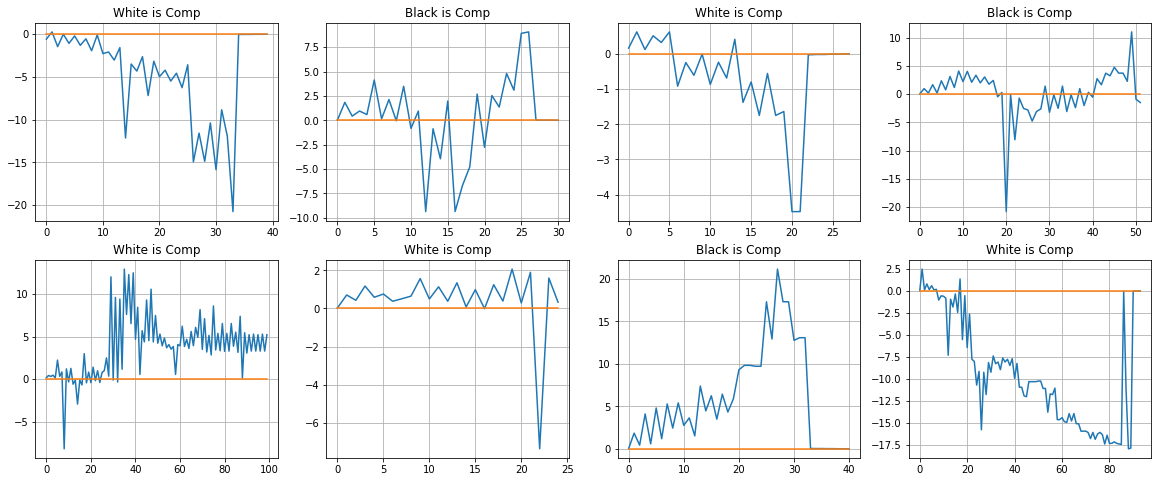

In [7]:
if game_counter >= 8:
    # viz first 8 games cpl 
    plt.subplots(figsize=(20,8))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.plot(df['cpl'][i])
        zeros = np.zeros(len(df['cpl'][i]))
        plt.plot(zeros)
        if df['Comp'][i] == 1:
            plt.title('White is Comp')
        else:
            plt.title('Black is Comp')
        plt.grid()
    plt.show()

In [8]:
# full data unique names
rerun_unique = False

In [9]:
if rerun_unique:
    df.White.unique()

In [10]:
if rerun_unique:
    df.Black.unique()

In [11]:
#TODO implement cp diff per half-move
#TODO implement search by player name
#TODO parse comments {[...]} in moves
#TODO try seaborn ?
#TODO read and parse any given amount of available headers mechanism
#TODO final df to SQL
#TODO stockfish vs stockfish eval

In [12]:
board.fen()

'8/8/5k1p/3p2p1/p2P1p2/8/7r/K4r2 w - - 2 48'